## Setting Up Your Python Environment

In [1]:
# %%capture
# # Install PyTorch with CUDA
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# # Install additional dependencies
# !pip install pandas pillow

# # Install ONNX packages
# !pip install onnx onnxruntime onnx-simplifier

# # Install utility packages
# !pip install cjm_psl_utils cjm_pil_utils

## Importing the Required Dependencies

In [2]:
# Import Python Standard Library dependencies
import json
from pathlib import Path
import random

# Import utility functions
from cjm_psl_utils.core import download_file
from cjm_pil_utils.core import resize_img

# Import numpy
import numpy as np

# Import the pandas package
import pandas as pd

# Import PIL for image manipulation
from PIL import Image, ImageDraw, ImageFont

# Import PyTorch dependencies
import torch

# Import ONNX dependencies
import onnx # Import the onnx module
from onnxsim import simplify # Import the method to simplify ONNX models
import onnxruntime as ort # Import the ONNX Runtime

## Setting Up the Project

### Set the Directory Paths

In [3]:
# The name for the project
project_name = f"pytorch-mask-r-cnn-instance-segmentation"

# The path for the project folder
project_dir = Path(f"./{project_name}/")

# Create the project directory if it does not already exist
project_dir.mkdir(parents=True, exist_ok=True)

# The path to the checkpoint folder
checkpoint_dir = Path(project_dir/f"2023-09-18_21-36-52")

pd.Series({
    "Project Directory:": project_dir,
    "Checkpoint Directory:": checkpoint_dir,
}).to_frame().style.hide(axis='columns')

Project Directory:,pytorch-mask-r-cnn-instance-segmentation
Checkpoint Directory:,pytorch-mask-r-cnn-instance-segmentation/2023-09-18_21-36-52


### Download a Font File

In [4]:
# Set the name of the font file
font_file = 'KFOlCnqEu92Fr1MmEU9vAw.ttf'

# Download the font file
download_file(f"https://fonts.gstatic.com/s/roboto/v30/{font_file}", "./")

The file ./KFOlCnqEu92Fr1MmEU9vAw.ttf already exists and overwrite is set to False.


## Loading the Checkpoint Data

### Load the Colormap

In [5]:
# The colormap path
colormap_path = list(checkpoint_dir.glob('*colormap.json'))[0]

# Load the JSON colormap data
with open(colormap_path, 'r') as file:
        colormap_json = json.load(file)

# Convert the JSON data to a dictionary        
colormap_dict = {item['label']: item['color'] for item in colormap_json['items']}

# Extract the class names from the colormap
class_names = list(colormap_dict.keys())

# Make a copy of the colormap in integer format
int_colors = [tuple(int(c*255) for c in color) for color in colormap_dict.values()]

### Load the Normalization Statistics

In [6]:
# The normalization stats path
norm_stats_path = checkpoint_dir/'norm_stats.json'

# Read the normalization stats from the JSON file
with open(norm_stats_path, "r") as f:
    norm_stats_dict = json.load(f)

# Convert the dictionary to a tuple
norm_stats = (norm_stats_dict["mean"], norm_stats_dict["std_dev"])

# Print the mean and standard deviation
pd.DataFrame(norm_stats)

,0,1,2
0,0.485,0.456,0.406
1,0.229,0.224,0.225


### Load the Model Checkpoint

In [7]:
# The model checkpoint path
checkpoint_path = list(checkpoint_dir.glob('*.pth'))[0]

# Load the model checkpoint onto the CPU
model_checkpoint = torch.load(checkpoint_path, map_location='cpu')

In [8]:
# model_checkpoint

### Load the Trained Mask R-CNN Model

In [9]:
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2, MaskRCNN
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [10]:
model = maskrcnn_resnet50_fpn_v2(weights='DEFAULT', 
                                 image_mean=norm_stats[0], 
                                 image_std=norm_stats[1]
                                )

model_type = 'maskrcnn_resnet50_fpn_v2'

In [11]:
# Get the number of input features for the classifier
in_features_box = model.roi_heads.box_predictor.cls_score.in_features
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels

num_classes = len(class_names)

# Replace the box predictor
model.roi_heads.box_predictor = FastRCNNPredictor(in_features_box, num_classes)

# Replace the mask predictor
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_channels=in_features_mask, dim_reduced=256, num_classes=num_classes)

# Initialize the model with the checkpoint parameters and buffers
model.load_state_dict(model_checkpoint)

<All keys matched successfully>

## Exporting the Model to ONNX

In [12]:
model.eval();

### Prepare the Input Tensor

In [13]:
input_tensor = torch.randn(1, 3, 256, 256)

In [14]:
# model

### Export the Model to ONNX

In [15]:
# Set a filename for the ONNX model
onnx_file_path = f"{checkpoint_dir}/{colormap_path.stem.removesuffix('-colormap')}-{model_type}.onnx"

# Export the PyTorch model to ONNX format
torch.onnx.export(model.cpu(),
                  input_tensor.cpu(),
                  onnx_file_path,
                  export_params=True,
                  do_constant_folding=False,
                  input_names = ['input'],
                  output_names = ['output'],
                  dynamic_axes={'input': {2 : 'height', 3 : 'width'}}
                 )

/home/innom-dt/mambaforge/envs/pytorch-env/lib/python3.11/site-packages/torch/nn/functional.py:3912: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  (torch.floor((input.size(i + 2).float() * torch.tensor(scale_factors[i], dtype=torch.float32)).float()))
/home/innom-dt/mambaforge/envs/pytorch-env/lib/python3.11/site-packages/torchvision/ops/boxes.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes_x = torch.min(boxes_x, torch.tensor(width, dtype=boxes.dtype, device=boxes.device))
/home/innom-dt/mambaforge/envs/pytorch-env/lib/python3.11/site-packages/torchvision/ops/boxes.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or 

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



### Simplify the ONNX Model

In [16]:
# Load the ONNX model from the onnx_file_name
onnx_model = onnx.load(onnx_file_path)

# Simplify the model
model_simp, check = simplify(onnx_model)

# Save the simplified model to the onnx_file_name
onnx.save(model_simp, onnx_file_path)

## Performing Inference with ONNX Runtime

### Create an Inference Session

In [17]:
# Load the model and create an InferenceSession
session = ort.InferenceSession(onnx_file_path)

2023-09-18 22:33:19.994940444 [W:onnxruntime:, graph.cc:3543 CleanUnusedInitializersAndNodeArgs] Removing initializer '2576'. It is not used by any node and should be removed from the model.
2023-09-18 22:33:19.994984631 [W:onnxruntime:, graph.cc:3543 CleanUnusedInitializersAndNodeArgs] Removing initializer '3079'. It is not used by any node and should be removed from the model.
2023-09-18 22:33:20.012108778 [W:onnxruntime:, graph.cc:3543 CleanUnusedInitializersAndNodeArgs] Removing initializer '32'. It is not used by any node and should be removed from the model.
2023-09-18 22:33:20.012118412 [W:onnxruntime:, graph.cc:3543 CleanUnusedInitializersAndNodeArgs] Removing initializer '2579'. It is not used by any node and should be removed from the model.
2023-09-18 22:33:20.012151539 [W:onnxruntime:, graph.cc:3543 CleanUnusedInitializersAndNodeArgs] Removing initializer '3083'. It is not used by any node and should be removed from the model.
2023-09-18 22:33:20.012153408 [W:onnxruntime:, 

### Define Utility Functions

#### Define a function to annotate an image with bounding boxes

In [18]:
def draw_bboxes_pil(image, boxes, labels, colors, font, width:int=2, font_size:int=18, probs=None):
    """
    Annotates an image with bounding boxes, labels, and optional probability scores.

    This function draws bounding boxes on the provided image using the given box coordinates, 
    colors, and labels. If probabilities are provided, they will be added to the labels.

    Parameters:
    image (PIL.Image): The input image on which annotations will be drawn.
    boxes (list of tuples): A list of bounding box coordinates where each tuple is (x, y, w, h).
    labels (list of str): A list of labels corresponding to each bounding box.
    colors (list of str): A list of colors for each bounding box and its corresponding label.
    font (str): Path to the font file to be used for displaying the labels.
    width (int, optional): Width of the bounding box lines. Defaults to 2.
    font_size (int, optional): Size of the font for the labels. Defaults to 25.
    probs (list of float, optional): A list of probability scores corresponding to each label. Defaults to None.

    Returns:
    annotated_image (PIL.Image): The image annotated with bounding boxes, labels, and optional probability scores.
    """
    
    # Define a reference diagonal
    REFERENCE_DIAGONAL = 1000
    
    # Scale the font size using the hypotenuse of the image
    font_size = int(font_size * (np.hypot(*image.size) / REFERENCE_DIAGONAL))
    
    # Add probability scores to labels
    if probs is not None:
        labels = [f"{label}: {prob*100:.2f}%" for label, prob in zip(labels, probs)]
    
    # Create a copy of the image
    annotated_image = image.copy()

    # Create an ImageDraw object for drawing on the image
    draw = ImageDraw.Draw(annotated_image)

    # Loop through the bounding boxes and labels in the 'annotation' DataFrame
    for i in range(len(labels)):
        # Get the bounding box coordinates
        x, y, x2, y2 = boxes[i]

        # Create a tuple of coordinates for the bounding box
        shape = (x, y, x2, y2)

        # Draw the bounding box on the image
        draw.rectangle(shape, outline=colors[i], width=width)
        
        # Load the font file
        fnt = ImageFont.truetype(font, font_size)
        
        # Draw the label box on the image
        label_w, label_h = draw.textbbox(xy=(0,0), text=labels[i], font=fnt)[2:]
        draw.rectangle((x, y-label_h, x+label_w, y), outline=colors[i], fill=colors[i], width=width)

        # Draw the label on the image
        draw.multiline_text((x, y-label_h), labels[i], font=fnt, fill='black' if np.mean(colors[i]) > 127.5 else 'white')
        
    return annotated_image

### Select a Test Image

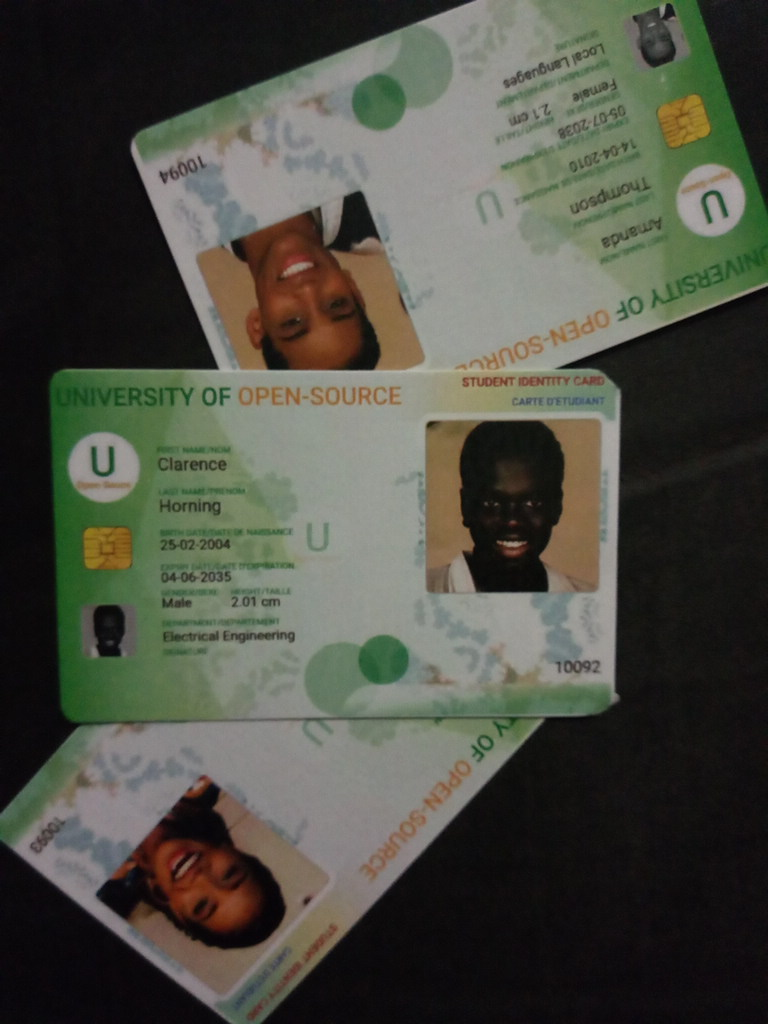

Test Image Size:,"(768, 1024)"


In [19]:
test_img_name = "10092.jpg"
# test_img_url = f"https://huggingface.co/datasets/cj-mills/pexel-hand-gesture-test-images/resolve/main/{test_img_name}"

# download_file(test_img_url, './', False)

test_img = Image.open(test_img_name)
display(test_img)

pd.Series({
    "Test Image Size:": test_img.size, 
}).to_frame().style.hide(axis='columns')

### Prepare the Test Image

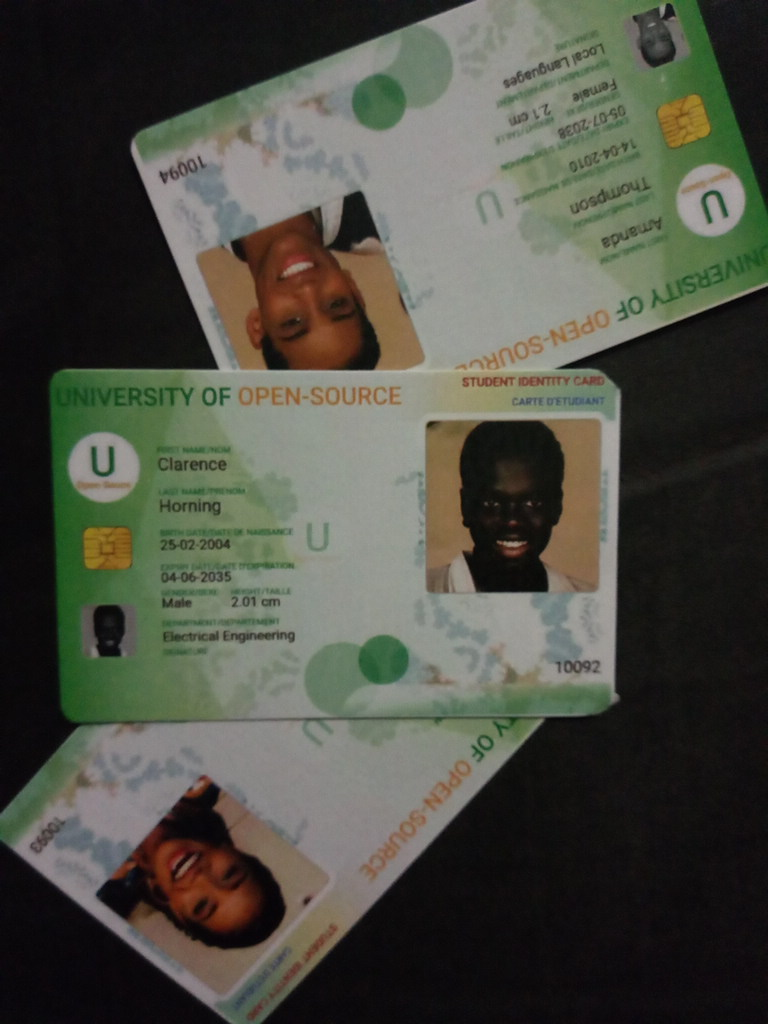

Source Image Size:,"(768, 1024)"
Input Dims:,"(512, 682)"
Min Image Scale:,1.500000
Input Image Size:,"(512, 682)"


In [20]:
# Set test image size
test_sz = 512

## Resize the test image
input_img = resize_img(test_img, target_sz=test_sz, divisor=1)

# Calculate the scale between the source image and the resized image
min_img_scale = min(test_img.size) / min(input_img.size)

# Ensure the input dimensions are multiples of the max stride
input_dims = input_img.size

display(test_img)

# Print the prediction data as a Pandas DataFrame for easy formatting
pd.Series({
    "Source Image Size:": test_img.size,
    "Input Dims:": input_dims,
    "Min Image Scale:": min_img_scale,
    "Input Image Size:": input_img.size
}).to_frame().style.hide(axis='columns')

### Prepare the Input Tensor

In [21]:
# Convert the existing input image to NumPy format
input_tensor_np = np.array(input_img, dtype=np.float32).transpose((2, 0, 1))[None]/255

In [22]:
def move_to_device(data, device):
    if isinstance(data, tuple):
        return tuple(move_to_device(d, device) for d in data)
    if isinstance(data, list):
        return list(move_to_device(d, device) for d in data)
    elif isinstance(data, dict):
        return {k: move_to_device(v, device) for k, v in data.items()}
    elif isinstance(data, torch.Tensor):
        return data.to(device)
    else:
        return data  # Non-tensor data types remain unchanged

### Compute the Predictions

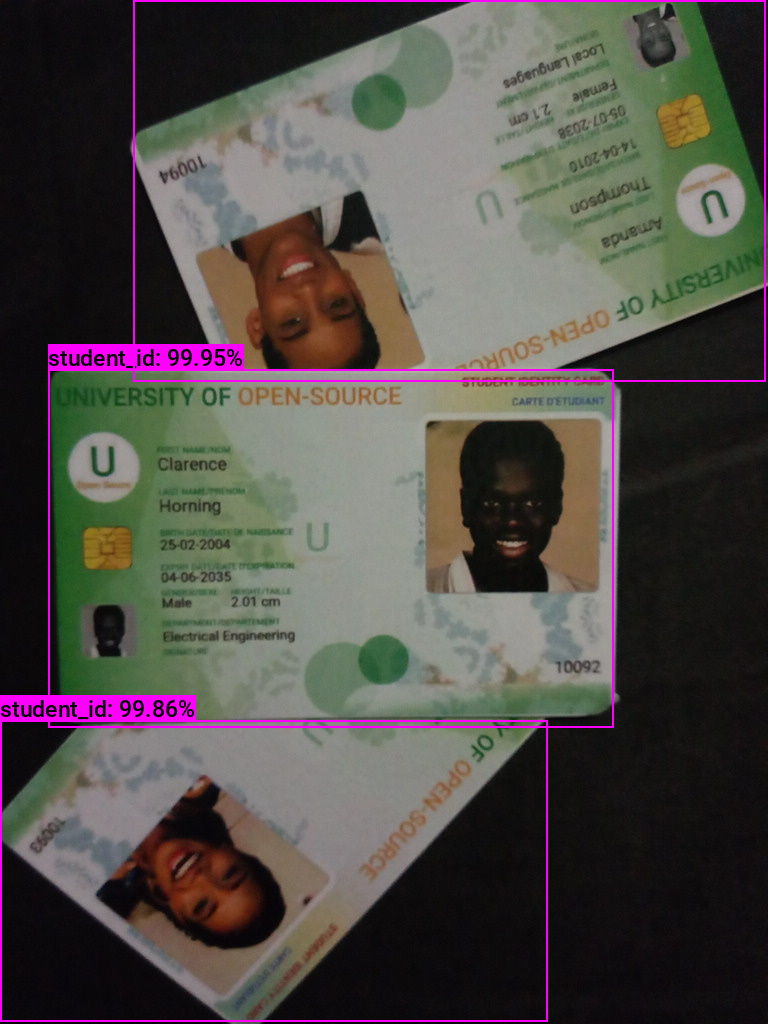

Predicted BBoxes:,"['student_id:[ 48.867 369.575 613.832 727.168]', 'student_id:[133.16 0. 765.688 381.278]', 'student_id:[ 0. 720.488 547.411 1021.915]']"
Confidence Scores:,"['student_id: 99.95%', 'student_id: 99.94%', 'student_id: 99.86%']"


In [23]:
# Run inference
outputs = session.run(None, {"input": input_tensor_np})

# Set the confidence threshold
threshold = 0.5

# Move model output to the CPU
model_output = move_to_device(outputs, 'cpu')

# Filter the output based on the confidence threshold
scores_mask = model_output[2] > threshold

bbox_list = (model_output[0][scores_mask])*min_img_scale
label_list = [class_names[int(idx)] for idx in model_output[1][scores_mask]]
probs_list = outputs[2]

annotated_img = draw_bboxes_pil(
    image=test_img, 
    boxes=bbox_list, 
    labels=label_list,
    probs=probs_list,
    colors=[int_colors[class_names.index(i)] for i in label_list], 
    font=font_file,
)

display(annotated_img)

# Print the prediction data as a Pandas Series for easy formatting
pd.Series({
    "Predicted BBoxes:": [f"{label}:{bbox}" for label, bbox in zip(label_list, bbox_list.round(decimals=3))],
    "Confidence Scores:": [f"{label}: {prob*100:.2f}%" for label, prob in zip(label_list, probs_list)]
}).to_frame().style.hide(axis='columns')